In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
import json
import statsmodels.api as sm

# Importing and Cleaning data

In [2]:
def cleanDf(df):
    # Dropping NaNs
    df.columns = ['Recipient', 'Supplier','Year of order', 'Year of order estimate','Number ordered', 
                  'Number ordered estimate', 'Weapon designation', 'Weapon description', 'Number delivered',
                    'Number delivered estimate', 'Year(s) of delivery', 'status', 'Comments', 'SIPRI TIV per unit',
                      'SIPRI TIV for total order', 'SIPRI TIV of delivered weapons']
    
    df['Year of order estimate'] = df['Year of order estimate'].notna()
    df['Number ordered estimate'] = df['Number ordered estimate'].notna()
    df['Number delivered estimate'] = df['Number delivered estimate'].notna()


    df = df.dropna(subset=['Number ordered','Number delivered','Year of order'])
    df['Number ordered'] = df['Number ordered'].astype('int')
    df['Number delivered'] = df['Number delivered'].astype('int')
    df['Year of order'] = df['Year of order'].astype('int')
    #df['Delivery start'] = df['Year(s) of delivery'].str.split(';').min()
    #df['Delivery end'] = df['Year(s) of delivery'].str.split(';').max()


    #Removing nonstate actors
    df = df[~df['Recipient'].str.contains('\*') & ~df['Supplier'].str.contains('\*')]

    #RESTRICT FOR YEARS [subject to change]
    df = df[df['Year of order'] >2001]

    #RESTRICT FOR NEW OR MODERNIZED
    df = df[df['status'] != 'Second hand']

    return df

In [3]:
aircraft_df = cleanDf(pd.read_csv("data/aircraft.csv",encoding='Latin1'))
armoured_vehicle_df = cleanDf(pd.read_csv("data/armoured_vehicle.csv",encoding='Latin1'))

In [ ]:
category_list = ['aircraft', 'armoured_vehicle', 'artillery','engines','missiles','naval_weapons','sensors','ships']
full_df = pd.DataFrame()
for category in category_list:
    this_df = cleanDf(pd.read_csv("data/"+ category +".csv",encoding='Latin1'))
    this_df['Weapon Category'] = category
    full_df = pd.concat((full_df, this_df),axis=0)
full_df.head(1)

array(['trainer/combat aircraft', 'transport helicopter',
       'combat helicopter', 'light helicopter', 'transport aircraft',
       'light transport aircraft', 'light aircraft', 'UAV', 'armed UAV',
       'helicopter', 'FGA aircraft', 'ASW helicopter',
       'maritime patrol aircraft', 'trainer/light aircraft',
       'trainer aircraft', 'tanker/transport aircraft', 'AEW&C aircraft',
       'heavy transport aircraft', 'FGA/EW aircraft', 'SIGINT aircraft',
       'ASW aircraft', 'fighter aircraft', 'reconnaissance aircraft',
       'anti-ship helicopter', 'AGS aircraft', 'AEW helicopter',
       'AEW/AGS aircraft', 'light/trainer aircraft',
       'ground attack aircraft', 'maritime patrol UAV',
       'reconnaissance/SIGINT aircraft', 'transport ac/helicopter',
       'light aircraft/UAV', 'airship', 'APV', 'APC', 'ALV', 'AFSV',
       'tank', 'light tank', 'APC/APV', 'IFV', 'armoured bridgelayer',
       'AEV', 'ARV', 'tank destroyer', 'armoured car', 'tank chassis',
       'AEV/A

In [5]:
aircraft_df.head(1)

,Recipient,Supplier,Year of order,Year of order estimate,Number ordered,Number ordered estimate,Weapon designation,Weapon description,Number delivered,Number delivered estimate,Year(s) of delivery,status,Comments,SIPRI TIV per unit,SIPRI TIV for total order,SIPRI TIV of delivered weapons
1,Afghanistan,Brazil,2013,False,20,False,EMB-314 Super Tucano,trainer/combat aircraft,20,True,2016,New,$427 m 'LAS' deal (financed by USA); A-29B ver...,4.5,90.0,90.0


# Creating Network From Edgelist


In [6]:
def create_network(df:pd.DataFrame,nodelist:set) -> nx.digraph:
    df = df[['Recipient','Supplier','SIPRI TIV of delivered weapons']]

    df = df[df['Recipient'].isin(nodelist) & df['Supplier'].isin(nodelist)]
    
    df = df.groupby(['Recipient','Supplier'])['SIPRI TIV of delivered weapons'].sum().to_frame().reset_index()
    
    network =  nx.from_pandas_edgelist(df, 'Supplier', 'Recipient', edge_attr='SIPRI TIV of delivered weapons', create_using=nx.DiGraph())
    network.add_nodes_from(nodelist)
    return network

In [7]:
with open('nodelist/nodelist_2001.json','r') as json_file:
    nodelist_budgets = json.load(json_file)
nodelist = set(nodelist_budgets.keys())

In [8]:
aircraft_graph = create_network(aircraft_df, nodelist)
vehicle_graph = create_network(armoured_vehicle_df,nodelist)

## Examining in-degrees and out-degrees

In [9]:
def powerlaw_test(data:list, cutoff:int):
    data[1] = data[1][:-1] #remove last value
    #data[0] = data[0][1:] # remove first value
    #data[1] = data[1][1:] # remove first value

    data[0] = data[0][:cutoff]
    data[1] = data[1][:cutoff]

    Y = np.log(data[0] + 1)
    X = np.log(data[1] + 1)
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    result = model.fit()
    print(result.summary())

# Out-degree plot

In [10]:
def plot_degree_distributions(net,cutoff, weighted:bool=False):
    if not weighted:
        out_degrees = dict(net.out_degree())
    else:
        out_degrees = dict(net.out_degree(weight='SIPRI TIV of delivered weapons'))
    

    #filtering out zeros
    #in_degrees = [in_degrees[country] for country in in_degrees if in_degrees[country]>0]
    #out_degrees = [out_degrees[country] for country in out_degrees if out_degrees[country]>0]
    out_degrees = [out_degrees[country] for country in out_degrees]

    """
    plt.figure(figsize=(5, 5))
    in_degree_hist = plt.hist(in_degrees, alpha=0.5, color='blue', label='In-degree')
    plt.xlabel('In-degree')
    plt.ylabel('Frequency')
    plt.title('Distribution of (nonzero) In-degrees')
    plt.grid(True)

    #plt.yscale('log')
    #plt.xscale('log')


    plt.legend()
    plt.show()
    """

    plt.figure(figsize=(6,5))
    out_degree_hist = plt.hist(out_degrees, alpha=0.5, color='red',density=True)
    plt.xlabel('Out-degree (exporters)')
    plt.ylabel('Proportion of Countries')
    plt.axvline(x=cutoff,label='cutoff for power law test',color='black',linestyle='--')
    plt.title('Distribution of Out-degrees')
    plt.grid(True)
    #plt.yscale('log')
    #plt.xscale('log')
    plt.legend(loc='upper right')
    plt.show()
    powerlaw_test(list(out_degree_hist), cutoff)


AIRCRAFT:


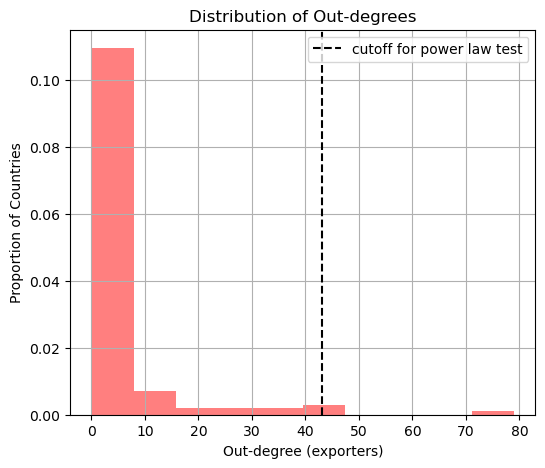

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     30.61
Date:                Tue, 23 Apr 2024   Prob (F-statistic):           0.000552
Time:                        17:37:34   Log-Likelihood:                 28.525
No. Observations:                  10   AIC:                            -53.05
Df Residuals:                       8   BIC:                            -52.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0829      0.014      6.043      0.0

c:\Users\bings\anaconda3\envs\ir_scraper\Lib\site-packages\scipy\stats\_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


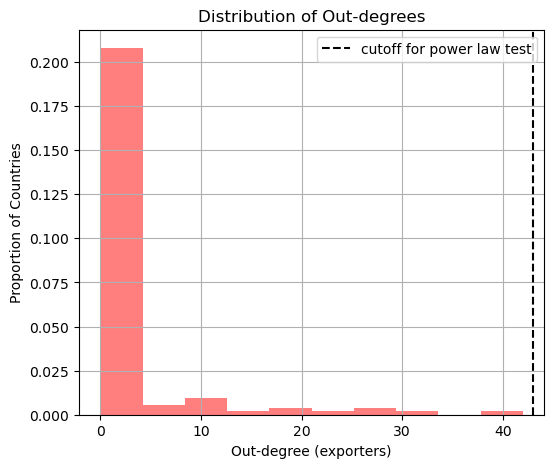

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     20.22
Date:                Tue, 23 Apr 2024   Prob (F-statistic):            0.00201
Time:                        17:37:35   Log-Likelihood:                 20.990
No. Observations:                  10   AIC:                            -37.98
Df Residuals:                       8   BIC:                            -37.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1392      0.028      4.951      0.0

c:\Users\bings\anaconda3\envs\ir_scraper\Lib\site-packages\scipy\stats\_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


In [11]:
print("AIRCRAFT:")
plot_degree_distributions(aircraft_graph, 43)
print("ARMORED VEHICLES:")
plot_degree_distributions(vehicle_graph, 43)

# Out-degree weighted by TIV

AIRCRAFT:


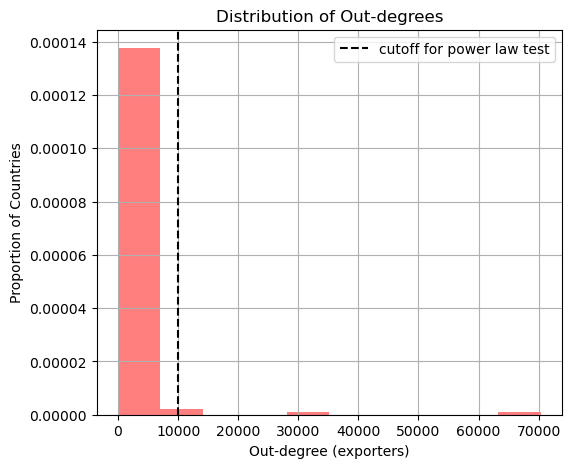

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     200.3
Date:                Tue, 23 Apr 2024   Prob (F-statistic):           6.04e-07
Time:                        17:37:35   Log-Likelihood:                 103.09
No. Observations:                  10   AIC:                            -202.2
Df Residuals:                       8   BIC:                            -201.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   8.84e-06     15.006      0.0

c:\Users\bings\anaconda3\envs\ir_scraper\Lib\site-packages\scipy\stats\_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


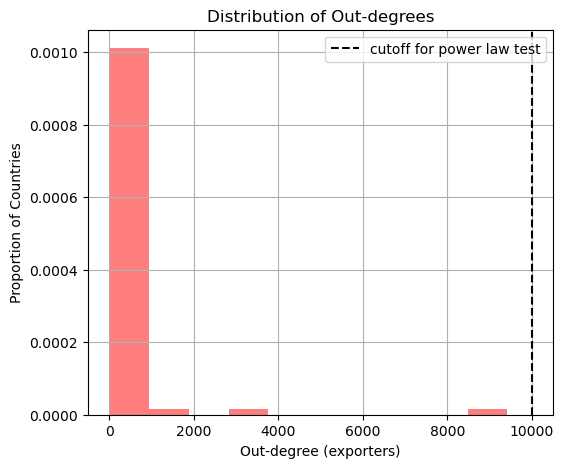

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     126.6
Date:                Tue, 23 Apr 2024   Prob (F-statistic):           3.49e-06
Time:                        17:37:35   Log-Likelihood:                 80.992
No. Observations:                  10   AIC:                            -158.0
Df Residuals:                       8   BIC:                            -157.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010   7.98e-05     11.969      0.0

c:\Users\bings\anaconda3\envs\ir_scraper\Lib\site-packages\scipy\stats\_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


In [12]:
print("AIRCRAFT:")
plot_degree_distributions(aircraft_graph,10000,weighted=True)
print("ARMORED VEHICLES:")
plot_degree_distributions(vehicle_graph,10000,weighted=True)

## Distribution of $\frac{InDegree}{OutDegree}$ Ratios

### Unweighted

In [13]:
def plot_degree_distributions(net):
    in_degrees = dict(net.in_degree())
    out_degrees = dict(net.out_degree())
    ratio = {country: out_degrees[country]/(in_degrees[country] + 1) for country in in_degrees}
    ratio = [ratio[country] for country in ratio]

    plt.figure(figsize=(8,5))

    out_degree_hist = plt.hist(ratio, alpha=0.5,bins = range(1,int(max(ratio)) + 2,1), color='red',density=False)

    plt.xlabel('OutDegree/InDegree')
    plt.ylabel('Number of Countries')
    plt.title('Distribution of (nonzero) Out-degrees')
    plt.grid(True)

    #plt.yscale('log')
    #plt.xscale('log')

    
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


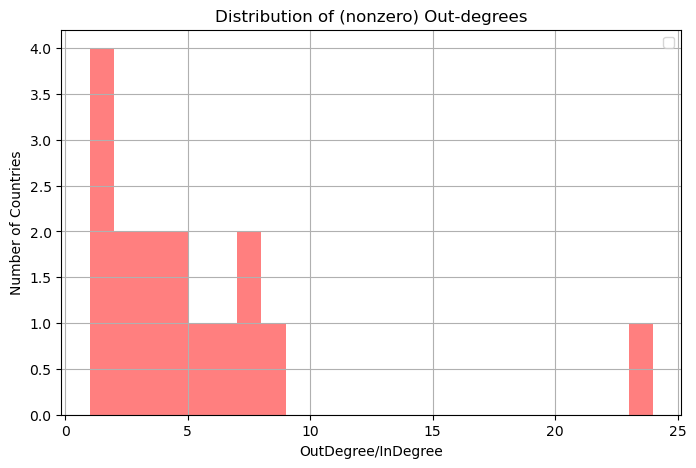

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


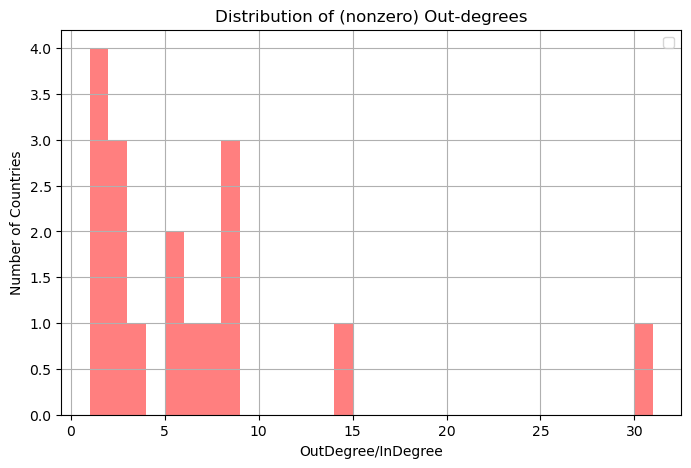

In [14]:
plot_degree_distributions(aircraft_graph)
plot_degree_distributions(vehicle_graph)

## Rank Correlation

In [15]:
aircraft_degrees = dict(sorted(aircraft_graph.out_degree()))
#aircraft_degrees = dict(sorted(aircraft_degrees.items(), key=lambda item: item[1]))
vehicle_degrees = dict(sorted(vehicle_graph.out_degree()))
assert list(aircraft_degrees.keys()) == list(vehicle_degrees.keys())
#vehicle_degrees = dict(sorted(vehicle_degrees.items(), key=lambda item: item[1]))

In [16]:
from scipy.stats import spearmanr
corr, p_value = spearmanr(list(aircraft_degrees.values()), list(vehicle_degrees.values()))
print(corr,p_value)

0.7540012228088155 2.1983624215279554e-24


If we remove all zero-out_degree values

In [17]:
vehicle_degrees = {country: vehicle_degrees[country] for country in vehicle_degrees if vehicle_degrees.get(country,0) != 0 or aircraft_degrees.get(country,1) != 0}
aircraft_degrees = {country: aircraft_degrees[country] for country in aircraft_degrees if vehicle_degrees.get(country,0) != 0 or aircraft_degrees.get(country,1) != 0}
assert len(aircraft_degrees) == len(vehicle_degrees)

corr, p_value = spearmanr(np.array(list(aircraft_degrees.values())), np.array(list(vehicle_degrees.values())))
print(corr,p_value)

0.5588898382672146 8.04299729319904e-05


In [18]:
more_vehicle = [country for country in vehicle_degrees if vehicle_degrees[country] > aircraft_degrees[country]]
more_aircraft = [country for country in aircraft_degrees if aircraft_degrees[country] > vehicle_degrees[country]]

## Ranked Correlation Weighted

In [19]:
aircraft_degrees = dict(sorted(aircraft_graph.out_degree(weight='SIPRI TIV of delivered weapons')))
vehicle_degrees = dict(sorted(vehicle_graph.out_degree(weight='SIPRI TIV of delivered weapons')))
assert list(aircraft_degrees.keys()) == list(vehicle_degrees.keys())

corr, p_value = spearmanr(list(aircraft_degrees.values()), list(vehicle_degrees.values()))
print(corr,p_value)

0.7613706553445486 4.284678107039371e-25


In [20]:
vehicle_degrees = {country: vehicle_degrees[country] for country in vehicle_degrees if vehicle_degrees.get(country,0) != 0 or aircraft_degrees.get(country,1) != 0}
aircraft_degrees = {country: aircraft_degrees[country] for country in aircraft_degrees if vehicle_degrees.get(country,0) != 0 or aircraft_degrees.get(country,1) != 0}
assert len(aircraft_degrees) == len(vehicle_degrees)

corr, p_value = spearmanr(np.array(list(aircraft_degrees.values())), np.array(list(vehicle_degrees.values())))
print(corr,p_value)

0.5661922281957242 6.17766497325023e-05


## Density of Bidirectional Versus Unidirectional Edges

In [21]:
aircraft_undirected = aircraft_graph.to_undirected(reciprocal=True)
vehicle_undirected = vehicle_graph.to_undirected(reciprocal=True)

In [22]:
print("aircraft:",nx.density(aircraft_undirected))
print("aircraft:",nx.density(aircraft_graph))

print("armored vehicles:", nx.density(vehicle_undirected))
print("armored vehicles:", nx.density(vehicle_graph))

aircraft: 0.0026666666666666666
aircraft: 0.031492063492063495
armored vehicles: 0.0008888888888888889
armored vehicles: 0.019301587301587302


## Graphing the Centrality of Nodes

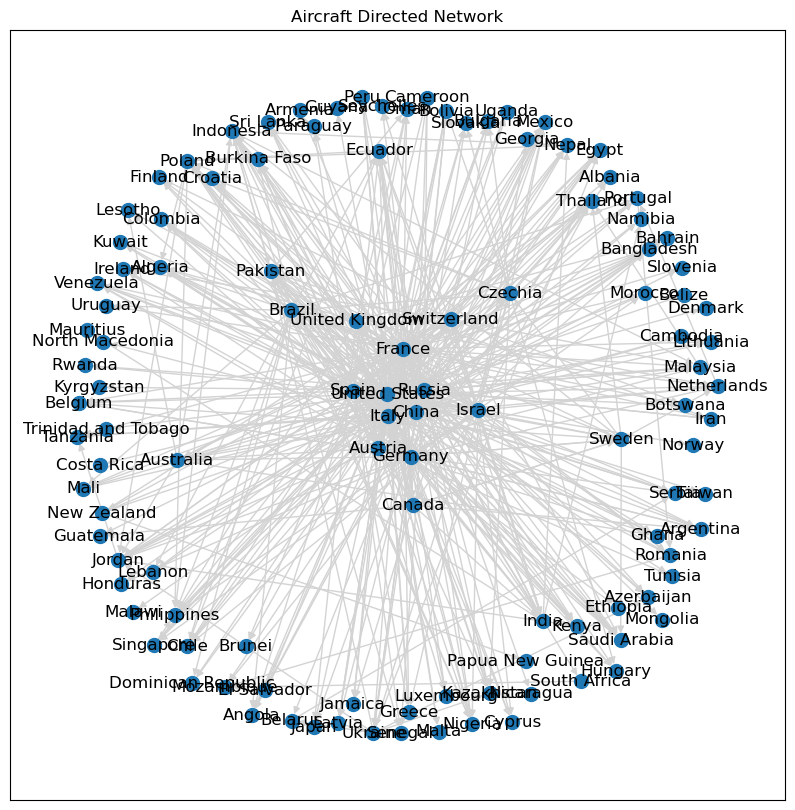

In [23]:
plt.figure(figsize=(10,10))
aircraft_graph.remove_nodes_from(list(nx.isolates(aircraft_graph)))
plt.title("Aircraft Directed Network")
pos = nx.spring_layout(aircraft_graph,k=1.5, center=(1,1),weight=3)
nx.draw_networkx(aircraft_graph, pos=pos, with_labels=True,node_size=100,edge_color='#D3D3D3')

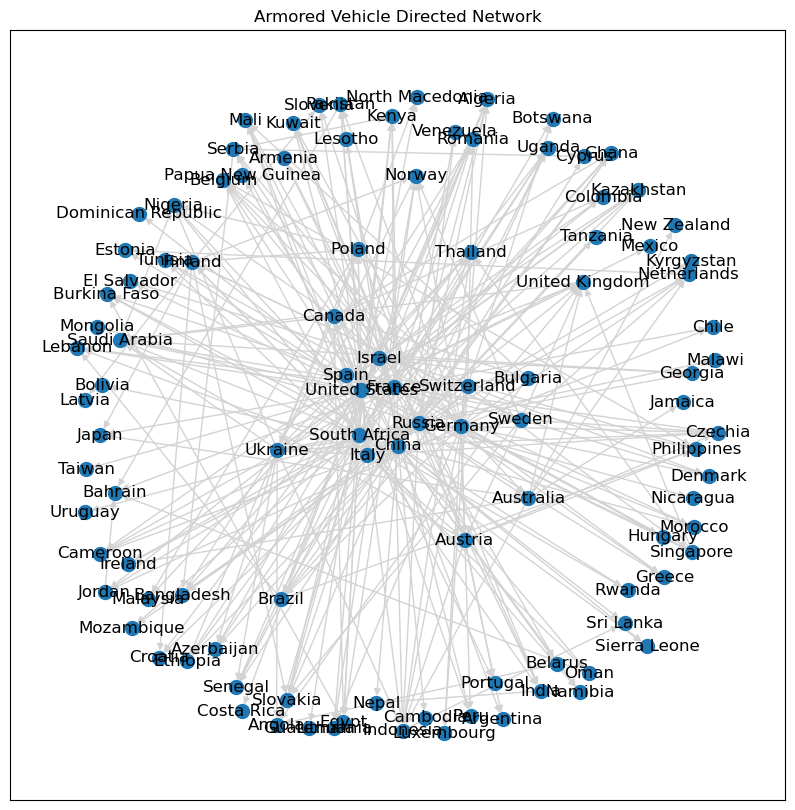

In [24]:
plt.figure(figsize=(10,10))
vehicle_graph.remove_nodes_from(list(nx.isolates(vehicle_graph)))
plt.title("Armored Vehicle Directed Network")
pos = nx.spring_layout(vehicle_graph,k=1.1, center=(1,1),weight=3)
nx.draw_networkx(vehicle_graph, pos=pos, with_labels=True,node_size=100,edge_color='#D3D3D3')

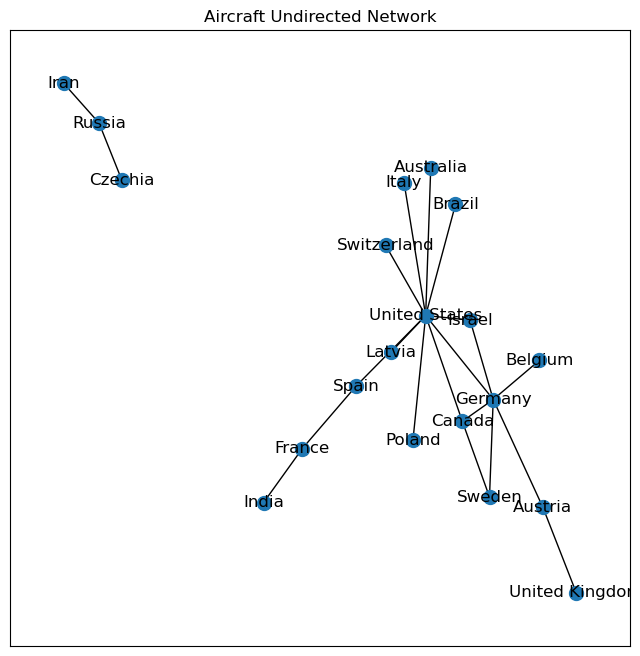

In [25]:
plt.figure(figsize=(8,8))
plt.title("Aircraft Undirected Network")
aircraft_undirected.remove_nodes_from(list(nx.isolates(aircraft_undirected)))
pos = nx.spring_layout(aircraft_undirected,k=0.25, center=(1,1),weight=3)
nx.draw_networkx(aircraft_undirected, pos=pos, with_labels=True,arrows=False,node_size=100)

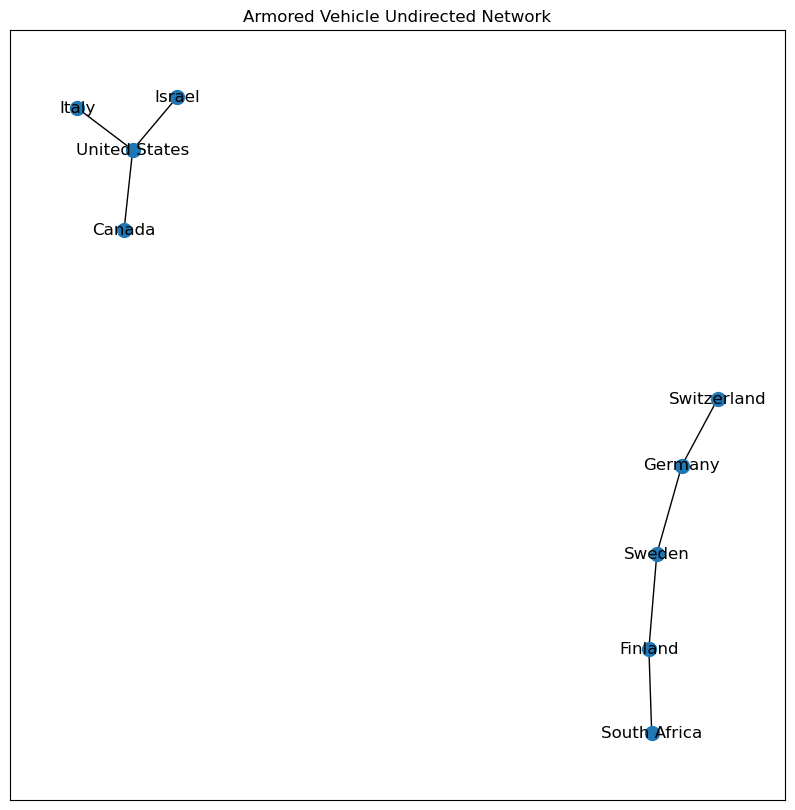

In [26]:
plt.figure(figsize=(10,10))
plt.title("Armored Vehicle Undirected Network")
vehicle_undirected.remove_nodes_from(list(nx.isolates(vehicle_undirected)))
pos = nx.spring_layout(vehicle_undirected,k=0.2, center=(1,1),weight=3)
nx.draw_networkx(vehicle_undirected, pos=pos, with_labels=True,arrows=False,node_size=100)